<a href="https://colab.research.google.com/github/jordicastro/fsDeepLearning/blob/main/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup YOLO and Data For Training

In [ ]:

# %ls
# ! unzip -qq YOLOX.zip
# ! unzip -qq character-detection-datasets.zip
# # %ls

%cd YOLOX
%ls

! pip install ninja
! pip install numpy
! pip install opencv_python
! pip install loguru
! pip install tqdm
! pip install thop
! pip install tabulate
! pip install psutil
! pip install tensorboard
! pip install pycocotools
! python setup.py build develop

/content/YOLOX
assets/  datasets/  demo/  docs/  exps/  setup.cfg  setup.py  tests/  tools/  yolox/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries for Training and Testing

In [ ]:
import os
from dataclasses import dataclass

from yolox.exp import Exp as MyExp


import argparse
import random
import warnings
from loguru import logger

import torch
import torch.backends.cudnn as cudnn

from yolox.exp import Exp, check_exp_value, get_exp
from yolox.utils import configure_module, configure_nccl, configure_omp, get_num_devices

from yolox.data.data_augment import ValTransform
import cv2
from yolox.utils import postprocess, vis
import time

import matplotlib.pyplot as plt

## Define Model and Training Config

In [ ]:
class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        # depth: the number of layers in the yolox 0.33 -> 0.5
            # smaller number means the model is faster but less accurate
        # TODO: change depth and width (model achitecture)
        self.depth = 0.67
        # width: the number of channels in each layer of the network
            # smaller number reduces computational complexity
        self.width = 0.75
        self.exp_name = "Character-Detection"
        # dataset paths
        self.data_dir = "/content/character-detection-datasets"
        self.train_ann = "train.json"
        self.val_ann = "test.json"
        # number of classes: 26 letters + 10 digits
        self.num_classes = 36
        # TODO: change to 300 epochs ~6 hours 30 -> 15
        self.max_epoch = 300
        # TODO: change 1 -> 10 (default) -> 30 ? how often the model is tested on the evaluation set
        self.eval_interval = 10
        # num CPU workers, maybe increase to speed up data loading TODO: increase?
        self.data_num_workers = 4
        # TODO: add learning rate
        self.min_lr_ratio = 0.01
        # TODO: add augmentation technique
          #  combine multiple images into one
        self.mosaic_prob = 0.5
          # blend two images and their labels
        self.mixup_prob = 0.5
          # Hue Saturation Value Color
        self.hsv_prob = 0.5
          # horizontal flipping (mirror?) we dont want that
        self.flip_prob = 0
          # image rotation +/- 10 deg
        self.degrees = 15.0
          # translate image randomly by 0.1 -> 10%
        self.translate = 0.1
          # mosaic scale
        self.mosaic_scale = (0.1, 2)
          # apply mixup aug or not
        self.enable_mixup = True
        self.mixup_scale = (0.5, 1.5)
          # max shear angle +/- 2
        self.shear = 2.0
          # num epochs at the end of training with NO augmentation 15 -> 5 -> 30
        self.no_aug_epochs = 30


        # TODO: (maybe) change testing config:
          # confidence threshold for filtering out non-confident detections 0.01 -> 0.05 prevent false positives
        self.test_conf = 0.4
          # threshold for filtering overlapping bounding boxes
            # higher, 0.8, allows more overlap
            # lower, 0.3, is more strict, less overlap
        self.nmsthre = 0.6

        # SCHEDULER:
            # options: yoloxwarmcos, warmcos, yoloxsemiwarmcos, multistep
        self.scheduler = "yoloxwarmcos"

        # warm up lr 0 -> 10% of lr = 0.005
        self.warmup_lr = 0.001

        # warm up epochs
        self.warmup_epochs = 20

        # activation function TRY relu
        self.act = "silu"

@dataclass
class TrainingConfig:
    experiment_name: str = "CharacterDetection"
    # TODO: change batch size; num images processed in one batch before updating weights and biases
    batch_size: int = 32
    # resume training from a checkpoint (a snapshot of the model's weights and biases)
    # CHANGE RESUME TO TRUE AND ADD CHECKPOINT EPOCH NUM
    resume: bool = False
    # checkpoint: path to checkpoint file to resume training
    ckpt: str = None
    start_epoch: int = 1
    # distributed training: use multiple GPUs to train the model
    num_machines: int = 1
    # machine_rank: the rank of the machine in the distributed training, meaning which machine gets which part of the data
    machine_rank: int = 0
    # enables half precision floating point training
        # this is faster and uses less memory, but may be less accurate
    fp16: bool = False
    # prevent def memory fragmentation (small gaps of memory wasted between blocks of memory)
    occupy: bool = False
    # logging framework
    logger: str = 'tensorboard'
    # directory to save checkpoints
    output_dir = 'checkpoints/'
    # path to cache data to speed up data loading
    cache: str = None

## Load Model and Train

In [ ]:
# create instances of arguments, experiment model, and trainer
args = TrainingConfig()
exp = Exp()
# train the model
trainer = exp.get_trainer(args)
trainer.train()

/content/YOLOX/yolox/core/trainer.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=args.fp16)
2025-02-14 04:29:08 | INFO     | yolox.core.trainer:132 - args: TrainingConfig(experiment_name='CharacterDetection', batch_size=32, resume=False, ckpt=None, start_epoch=1, num_machines=1, machine_rank=0, fp16=False, occupy=False, logger='tensorboard', cache=None)
2025-02-14 04:29:08 | INFO     | yolox.core.trainer:133 - exp value:
╒═══════════════════╤═════════════════════════════════════════╕
│ keys              │ values                                  │
╞═══════════════════╪═════════════════════════════════════════╡
│ seed              │ None                                    │
├───────────────────┼─────────────────────────────────────────┤
│ output_dir        │ './YOLOX_outputs'                       │
├───────────────────┼─────────────────────────────────

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


2025-02-14 04:29:10 | INFO     | yolox.core.trainer:157 - init prefetcher, this might take one minute or less...
2025-02-14 04:29:12 | INFO     | yolox.core.trainer:196 - Training start...
2025-02-14 04:29:12 | INFO     | yolox.core.trainer:197 - 
YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(96, 48, kernel_size=(1, 1), st

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/content/YOLOX/yolox/core/trainer.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.amp_training):
/content/YOLOX/yolox/models/yolo_head.py:474: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
2025-02-14 04:29:18 | INFO     | yolox.core.trainer:270 - epoch: 1/300, iter: 10/65, gpu mem: 22154Mb, mem: 3.5Gb, iter_time: 0.679s, data_time: 0.002s, total_loss: 17.4, iou_loss: 4.6, l1_loss: 0.0, conf_loss: 11.3, cls_loss: 1.5, lr: 1.000e-03, size: 640, ETA: 3:40:43
2025-02-14 04:29:22 | INFO     | yolox.core.trainer:270 - epoch: 1/300, iter: 20/65, gpu mem: 22154Mb, mem: 3.5Gb, iter_time: 0.374s, data_time: 0.003s, total_loss: 12.7, iou_loss: 4.1, l1_loss: 0.0, conf_loss: 6.5, cls_loss: 2.1, lr: 1.001e-03, size: 608, ETA: 2:50:59
2025-02-14 04:29:26

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 04:33:51 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.64 ms, Average NMS time: 1.58 ms, Average inference time: 4.22 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.385
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 04:33:51 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 04:33:52 | INFO     | yolox.core.trainer:218 - ---> start train epoch11
2025-02-14 04:33:56 | INFO     | yolox.core.trainer:270 - epoch: 11/300, iter: 10/65, gpu mem: 34194Mb, mem: 3.9Gb, iter_time: 0.493s, data_time: 0.002s, total_loss: 5.4, iou_loss: 2.0, l1_loss: 0.0, conf_loss: 2.2, cls_loss: 1.3, lr: 2.031e-03, size: 768, ETA: 2:10:31
2025-02-14 04:34:00 | INFO     | yolox.core.trainer:270 - epoch: 11/300, iter: 20/65, gpu mem: 34194Mb, mem: 3.9Gb, iter_time: 0.390s, data_time: 0.001s, total_loss: 4.8, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.7, cls_loss: 1.2, lr: 2.062e-03, size: 640, ETA: 2:10:20
2025-02-14 04:34:04 | INFO     | yolox.core.trainer:270 - epoch: 11/300, iter: 30/65, gpu mem: 34194Mb, mem: 3.9Gb, iter_time: 0.373s, data_time: 0.002s, total_loss: 4.7, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.7, cls_loss: 1.2, lr: 2.094e-03, size: 608, ETA: 2:10:0

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 04:38:23 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.75 ms, Average inference time: 2.82 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.476
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.368
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.519
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.492
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.530
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.530
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.383
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.52 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 04:38:24 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 04:38:24 | INFO     | yolox.core.trainer:218 - ---> start train epoch21
2025-02-14 04:38:29 | INFO     | yolox.core.trainer:270 - epoch: 21/300, iter: 10/65, gpu mem: 34195Mb, mem: 3.8Gb, iter_time: 0.478s, data_time: 0.002s, total_loss: 4.2, iou_loss: 1.9, l1_loss: 0.0, conf_loss: 1.4, cls_loss: 1.0, lr: 5.000e-03, size: 736, ETA: 2:04:11
2025-02-14 04:38:33 | INFO     | yolox.core.trainer:270 - epoch: 21/300, iter: 20/65, gpu mem: 34195Mb, mem: 3.9Gb, iter_time: 0.347s, data_time: 0.002s, total_loss: 4.0, iou_loss: 1.8, l1_loss: 0.0, conf_loss: 1.2, cls_loss: 1.0, lr: 5.000e-03, size: 576, ETA: 2:03:59
2025-02-14 04:38:37 | INFO     | yolox.core.trainer:270 - epoch: 21/300, iter: 30/65, gpu mem: 34195Mb, mem: 3.9Gb, iter_time: 0.417s, data_time: 0.002s, total_loss: 4.2, iou_loss: 2.0, l1_loss: 0.0, conf_loss: 1.3, cls_loss: 0.9, lr: 5.000e-03, size: 672, ETA: 2:03:5

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 04:43:00 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.80 ms, Average inference time: 2.87 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.931
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.847
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.574
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.665
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 04:43:01 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 04:43:01 | INFO     | yolox.core.trainer:218 - ---> start train epoch31
2025-02-14 04:43:04 | INFO     | yolox.core.trainer:270 - epoch: 31/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.297s, data_time: 0.002s, total_loss: 3.3, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 4.980e-03, size: 512, ETA: 1:59:33
2025-02-14 04:43:10 | INFO     | yolox.core.trainer:270 - epoch: 31/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.563s, data_time: 0.002s, total_loss: 3.4, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.8, lr: 4.979e-03, size: 800, ETA: 1:59:42
2025-02-14 04:43:13 | INFO     | yolox.core.trainer:270 - epoch: 31/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.331s, data_time: 0.002s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.8, lr: 4.979e-03, size: 544, ETA: 1:59:3

Loading and preparing results...
DONE (t=0.33s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 04:47:26 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.77 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.688
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.965
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.845
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.710
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 04:47:27 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 04:47:27 | INFO     | yolox.core.trainer:218 - ---> start train epoch41
2025-02-14 04:47:32 | INFO     | yolox.core.trainer:270 - epoch: 41/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.474s, data_time: 0.002s, total_loss: 3.6, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 1.0, cls_loss: 0.8, lr: 4.921e-03, size: 736, ETA: 1:54:10
2025-02-14 04:47:35 | INFO     | yolox.core.trainer:270 - epoch: 41/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.373s, data_time: 0.002s, total_loss: 3.3, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 4.920e-03, size: 608, ETA: 1:54:04
2025-02-14 04:47:39 | INFO     | yolox.core.trainer:270 - epoch: 41/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.371s, data_time: 0.002s, total_loss: 3.3, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 4.919e-03, size: 608, ETA: 1:53:5

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 04:51:53 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.81 ms, Average inference time: 2.88 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.969
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.617
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.741
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.702
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 04:51:54 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 04:51:55 | INFO     | yolox.core.trainer:218 - ---> start train epoch51
2025-02-14 04:52:00 | INFO     | yolox.core.trainer:270 - epoch: 51/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.7Gb, iter_time: 0.493s, data_time: 0.002s, total_loss: 3.1, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.9, cls_loss: 0.7, lr: 4.824e-03, size: 768, ETA: 1:49:17
2025-02-14 04:52:04 | INFO     | yolox.core.trainer:270 - epoch: 51/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.441s, data_time: 0.002s, total_loss: 3.2, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 4.823e-03, size: 704, ETA: 1:49:15
2025-02-14 04:52:09 | INFO     | yolox.core.trainer:270 - epoch: 51/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.535s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.5, lr: 4.821e-03, size: 768, ETA: 1:49:1

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 04:56:22 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.722
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.972
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.921
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.724
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 04:56:22 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 04:56:23 | INFO     | yolox.core.trainer:218 - ---> start train epoch61
2025-02-14 04:56:26 | INFO     | yolox.core.trainer:270 - epoch: 61/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.352s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 4.692e-03, size: 576, ETA: 1:44:32
2025-02-14 04:56:30 | INFO     | yolox.core.trainer:270 - epoch: 61/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.335s, data_time: 0.002s, total_loss: 3.2, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 4.689e-03, size: 544, ETA: 1:44:25
2025-02-14 04:56:33 | INFO     | yolox.core.trainer:270 - epoch: 61/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.385s, data_time: 0.001s, total_loss: 3.0, iou_loss: 1.7, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 4.687e-03, size: 640, ETA: 1:44:2

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:00:51 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.80 ms, Average inference time: 2.87 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.724
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.979
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.897
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.51 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:00:53 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:00:53 | INFO     | yolox.core.trainer:218 - ---> start train epoch71
2025-02-14 05:00:57 | INFO     | yolox.core.trainer:270 - epoch: 71/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.420s, data_time: 0.002s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 4.525e-03, size: 672, ETA: 1:40:06
2025-02-14 05:01:02 | INFO     | yolox.core.trainer:270 - epoch: 71/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.7Gb, iter_time: 0.473s, data_time: 0.002s, total_loss: 2.8, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 4.522e-03, size: 736, ETA: 1:40:04
2025-02-14 05:01:05 | INFO     | yolox.core.trainer:270 - epoch: 71/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.299s, data_time: 0.002s, total_loss: 3.3, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.9, lr: 4.519e-03, size: 512, ETA: 1:39:5

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:05:26 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.82 ms, Average inference time: 2.89 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.725
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.980
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.919
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.728
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.22 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:05:27 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:05:27 | INFO     | yolox.core.trainer:218 - ---> start train epoch81
2025-02-14 05:05:30 | INFO     | yolox.core.trainer:270 - epoch: 81/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.329s, data_time: 0.002s, total_loss: 3.2, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.8, lr: 4.326e-03, size: 544, ETA: 1:35:50
2025-02-14 05:05:35 | INFO     | yolox.core.trainer:270 - epoch: 81/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.470s, data_time: 0.002s, total_loss: 3.0, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 4.323e-03, size: 736, ETA: 1:35:48
2025-02-14 05:05:38 | INFO     | yolox.core.trainer:270 - epoch: 81/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.330s, data_time: 0.002s, total_loss: 3.0, iou_loss: 1.6, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 4.319e-03, size: 544, ETA: 1:35:4

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:09:55 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.79 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.733
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.934
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.735
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.762
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.725
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:09:56 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:09:56 | INFO     | yolox.core.trainer:218 - ---> start train epoch91
2025-02-14 05:10:00 | INFO     | yolox.core.trainer:270 - epoch: 91/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.352s, data_time: 0.002s, total_loss: 2.9, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.8, lr: 4.099e-03, size: 576, ETA: 1:31:23
2025-02-14 05:10:03 | INFO     | yolox.core.trainer:270 - epoch: 91/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.292s, data_time: 0.002s, total_loss: 2.8, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 4.095e-03, size: 480, ETA: 1:31:16
2025-02-14 05:10:08 | INFO     | yolox.core.trainer:270 - epoch: 91/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.7Gb, iter_time: 0.539s, data_time: 0.002s, total_loss: 3.0, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.8, cls_loss: 0.7, lr: 4.092e-03, size: 768, ETA: 1:31:1

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:14:32 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.79 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.944
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.682
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.762
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.791
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.748
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.52 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:14:33 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:14:33 | INFO     | yolox.core.trainer:218 - ---> start train epoch101
2025-02-14 05:14:36 | INFO     | yolox.core.trainer:270 - epoch: 101/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.285s, data_time: 0.002s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 3.847e-03, size: 480, ETA: 1:27:11
2025-02-14 05:14:41 | INFO     | yolox.core.trainer:270 - epoch: 101/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.438s, data_time: 0.002s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.7, cls_loss: 0.7, lr: 3.843e-03, size: 704, ETA: 1:27:08
2025-02-14 05:14:46 | INFO     | yolox.core.trainer:270 - epoch: 101/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.7Gb, iter_time: 0.493s, data_time: 0.002s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 3.839e-03, size: 768, ETA: 1:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:19:02 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.77 ms, Average inference time: 2.84 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.761
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.948
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.761
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.746
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:19:03 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:19:03 | INFO     | yolox.core.trainer:218 - ---> start train epoch111
2025-02-14 05:19:06 | INFO     | yolox.core.trainer:270 - epoch: 111/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.348s, data_time: 0.002s, total_loss: 2.8, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 3.574e-03, size: 576, ETA: 1:22:46
2025-02-14 05:19:10 | INFO     | yolox.core.trainer:270 - epoch: 111/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.384s, data_time: 0.001s, total_loss: 2.7, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.7, lr: 3.570e-03, size: 640, ETA: 1:22:42
2025-02-14 05:19:14 | INFO     | yolox.core.trainer:270 - epoch: 111/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.341s, data_time: 0.002s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 3.566e-03, size: 576, ETA: 1:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:23:54 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.79 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.751
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:23:55 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:23:55 | INFO     | yolox.core.trainer:218 - ---> start train epoch121
2025-02-14 05:23:58 | INFO     | yolox.core.trainer:270 - epoch: 121/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.333s, data_time: 0.002s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 3.285e-03, size: 544, ETA: 1:18:54
2025-02-14 05:24:02 | INFO     | yolox.core.trainer:270 - epoch: 121/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.349s, data_time: 0.003s, total_loss: 2.5, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 3.281e-03, size: 576, ETA: 1:18:49
2025-02-14 05:24:07 | INFO     | yolox.core.trainer:270 - epoch: 121/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.7Gb, iter_time: 0.494s, data_time: 0.003s, total_loss: 2.5, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 3.276e-03, size: 768, ETA: 1:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:28:24 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.83 ms, Average inference time: 2.91 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.950
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.686
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.752
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:28:25 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:28:25 | INFO     | yolox.core.trainer:218 - ---> start train epoch131
2025-02-14 05:28:29 | INFO     | yolox.core.trainer:270 - epoch: 131/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.379s, data_time: 0.002s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 2.984e-03, size: 608, ETA: 1:14:26
2025-02-14 05:28:33 | INFO     | yolox.core.trainer:270 - epoch: 131/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.387s, data_time: 0.001s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 2.979e-03, size: 640, ETA: 1:14:22
2025-02-14 05:28:36 | INFO     | yolox.core.trainer:270 - epoch: 131/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.301s, data_time: 0.003s, total_loss: 2.9, iou_loss: 1.5, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.8, lr: 2.975e-03, size: 512, ETA: 1:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:32:53 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.81 ms, Average inference time: 2.89 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.709
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.733
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.20 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:32:53 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:32:54 | INFO     | yolox.core.trainer:218 - ---> start train epoch141
2025-02-14 05:32:58 | INFO     | yolox.core.trainer:270 - epoch: 141/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.437s, data_time: 0.002s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 2.676e-03, size: 704, ETA: 1:09:59
2025-02-14 05:33:02 | INFO     | yolox.core.trainer:270 - epoch: 141/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.349s, data_time: 0.003s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 2.671e-03, size: 576, ETA: 1:09:55
2025-02-14 05:33:06 | INFO     | yolox.core.trainer:270 - epoch: 141/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.476s, data_time: 0.002s, total_loss: 2.2, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 2.666e-03, size: 736, ETA: 1:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:37:33 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.691
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.52 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:37:33 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:37:34 | INFO     | yolox.core.trainer:218 - ---> start train epoch151
2025-02-14 05:37:37 | INFO     | yolox.core.trainer:270 - epoch: 151/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.300s, data_time: 0.003s, total_loss: 2.3, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 2.365e-03, size: 512, ETA: 1:05:43
2025-02-14 05:37:41 | INFO     | yolox.core.trainer:270 - epoch: 151/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.440s, data_time: 0.002s, total_loss: 2.4, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 2.360e-03, size: 704, ETA: 1:05:39
2025-02-14 05:37:44 | INFO     | yolox.core.trainer:270 - epoch: 151/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.333s, data_time: 0.002s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 2.355e-03, size: 544, ETA: 1:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:42:06 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.86 ms, Average inference time: 2.94 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.54 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:42:07 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:42:07 | INFO     | yolox.core.trainer:218 - ---> start train epoch161
2025-02-14 05:42:11 | INFO     | yolox.core.trainer:270 - epoch: 161/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.374s, data_time: 0.002s, total_loss: 2.2, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 2.057e-03, size: 608, ETA: 1:01:20
2025-02-14 05:42:14 | INFO     | yolox.core.trainer:270 - epoch: 161/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.296s, data_time: 0.002s, total_loss: 2.3, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 2.052e-03, size: 512, ETA: 1:01:15
2025-02-14 05:42:17 | INFO     | yolox.core.trainer:270 - epoch: 161/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.347s, data_time: 0.002s, total_loss: 1.9, iou_loss: 1.0, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 2.047e-03, size: 576, ETA: 1:

Loading and preparing results...
DONE (t=0.33s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:46:42 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.80 ms, Average inference time: 2.87 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.963
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.730
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.751
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:46:43 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:46:43 | INFO     | yolox.core.trainer:218 - ---> start train epoch171
2025-02-14 05:46:48 | INFO     | yolox.core.trainer:270 - epoch: 171/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.442s, data_time: 0.002s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.756e-03, size: 704, ETA: 0:57:00
2025-02-14 05:46:51 | INFO     | yolox.core.trainer:270 - epoch: 171/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.300s, data_time: 0.002s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.751e-03, size: 512, ETA: 0:56:55
2025-02-14 05:46:55 | INFO     | yolox.core.trainer:270 - epoch: 171/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.373s, data_time: 0.002s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.747e-03, size: 608, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:51:21 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.84 ms, Average inference time: 2.91 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.963
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.721
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.773
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.52 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:51:21 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:51:21 | INFO     | yolox.core.trainer:218 - ---> start train epoch181
2025-02-14 05:51:26 | INFO     | yolox.core.trainer:270 - epoch: 181/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.481s, data_time: 0.002s, total_loss: 2.1, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.467e-03, size: 736, ETA: 0:52:40
2025-02-14 05:51:31 | INFO     | yolox.core.trainer:270 - epoch: 181/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.429s, data_time: 0.002s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.463e-03, size: 672, ETA: 0:52:36
2025-02-14 05:51:34 | INFO     | yolox.core.trainer:270 - epoch: 181/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.303s, data_time: 0.002s, total_loss: 2.4, iou_loss: 1.3, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.458e-03, size: 512, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 05:55:40 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.79 ms, Average inference time: 2.87 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.958
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.20 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 05:55:41 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 05:55:41 | INFO     | yolox.core.trainer:218 - ---> start train epoch191
2025-02-14 05:55:44 | INFO     | yolox.core.trainer:270 - epoch: 191/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.298s, data_time: 0.002s, total_loss: 2.4, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.6, lr: 1.195e-03, size: 512, ETA: 0:48:07
2025-02-14 05:55:48 | INFO     | yolox.core.trainer:270 - epoch: 191/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.396s, data_time: 0.002s, total_loss: 2.1, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.191e-03, size: 608, ETA: 0:48:03
2025-02-14 05:55:52 | INFO     | yolox.core.trainer:270 - epoch: 191/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.417s, data_time: 0.002s, total_loss: 2.2, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 1.187e-03, size: 672, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:00:11 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.77 ms, Average inference time: 2.84 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.957
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.722
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.22 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:00:12 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:00:12 | INFO     | yolox.core.trainer:218 - ---> start train epoch201
2025-02-14 06:00:15 | INFO     | yolox.core.trainer:270 - epoch: 201/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.288s, data_time: 0.002s, total_loss: 2.6, iou_loss: 1.4, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.7, lr: 9.437e-04, size: 480, ETA: 0:43:43
2025-02-14 06:00:21 | INFO     | yolox.core.trainer:270 - epoch: 201/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.576s, data_time: 0.002s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 9.400e-04, size: 800, ETA: 0:43:40
2025-02-14 06:00:24 | INFO     | yolox.core.trainer:270 - epoch: 201/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.301s, data_time: 0.003s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 9.363e-04, size: 512, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:04:56 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:04:57 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:04:57 | INFO     | yolox.core.trainer:218 - ---> start train epoch211
2025-02-14 06:05:01 | INFO     | yolox.core.trainer:270 - epoch: 211/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.419s, data_time: 0.002s, total_loss: 2.2, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 7.175e-04, size: 672, ETA: 0:39:26
2025-02-14 06:05:06 | INFO     | yolox.core.trainer:270 - epoch: 211/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.489s, data_time: 0.002s, total_loss: 2.1, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 7.143e-04, size: 768, ETA: 0:39:23
2025-02-14 06:05:11 | INFO     | yolox.core.trainer:270 - epoch: 211/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.490s, data_time: 0.002s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.4, lr: 7.110e-04, size: 768, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:09:38 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.79 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.20 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:09:39 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:09:39 | INFO     | yolox.core.trainer:218 - ---> start train epoch221
2025-02-14 06:09:44 | INFO     | yolox.core.trainer:270 - epoch: 221/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.8Gb, iter_time: 0.474s, data_time: 0.002s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 5.199e-04, size: 736, ETA: 0:35:06
2025-02-14 06:09:48 | INFO     | yolox.core.trainer:270 - epoch: 221/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.386s, data_time: 0.002s, total_loss: 1.8, iou_loss: 1.0, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 5.171e-04, size: 640, ETA: 0:35:02
2025-02-14 06:09:51 | INFO     | yolox.core.trainer:270 - epoch: 221/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.298s, data_time: 0.002s, total_loss: 2.1, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 5.143e-04, size: 512, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:14:14 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.715
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:14:14 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:14:15 | INFO     | yolox.core.trainer:218 - ---> start train epoch231
2025-02-14 06:14:18 | INFO     | yolox.core.trainer:270 - epoch: 231/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.347s, data_time: 0.002s, total_loss: 2.0, iou_loss: 1.0, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 3.538e-04, size: 576, ETA: 0:30:43
2025-02-14 06:14:22 | INFO     | yolox.core.trainer:270 - epoch: 231/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.348s, data_time: 0.003s, total_loss: 2.2, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 3.515e-04, size: 576, ETA: 0:30:38
2025-02-14 06:14:25 | INFO     | yolox.core.trainer:270 - epoch: 231/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.350s, data_time: 0.002s, total_loss: 2.3, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.6, cls_loss: 0.5, lr: 3.493e-04, size: 576, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:18:51 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.715
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:18:51 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:18:51 | INFO     | yolox.core.trainer:218 - ---> start train epoch241
2025-02-14 06:18:56 | INFO     | yolox.core.trainer:270 - epoch: 241/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.471s, data_time: 0.002s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 2.220e-04, size: 736, ETA: 0:26:20
2025-02-14 06:19:00 | INFO     | yolox.core.trainer:270 - epoch: 241/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.332s, data_time: 0.002s, total_loss: 2.2, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 2.203e-04, size: 544, ETA: 0:26:16
2025-02-14 06:19:04 | INFO     | yolox.core.trainer:270 - epoch: 241/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.419s, data_time: 0.002s, total_loss: 1.7, iou_loss: 1.0, l1_loss: 0.0, conf_loss: 0.3, cls_loss: 0.4, lr: 2.186e-04, size: 672, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:23:16 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.77 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.746
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.20 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:23:17 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:23:17 | INFO     | yolox.core.trainer:218 - ---> start train epoch251
2025-02-14 06:23:21 | INFO     | yolox.core.trainer:270 - epoch: 251/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.384s, data_time: 0.001s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.5, lr: 1.266e-04, size: 640, ETA: 0:21:54
2025-02-14 06:23:26 | INFO     | yolox.core.trainer:270 - epoch: 251/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.473s, data_time: 0.002s, total_loss: 1.9, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.4, cls_loss: 0.4, lr: 1.254e-04, size: 736, ETA: 0:21:50
2025-02-14 06:23:30 | INFO     | yolox.core.trainer:270 - epoch: 251/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.437s, data_time: 0.002s, total_loss: 2.0, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.5, lr: 1.242e-04, size: 704, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:27:57 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.78 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.812
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:27:58 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:27:58 | INFO     | yolox.core.trainer:218 - ---> start train epoch261
2025-02-14 06:28:01 | INFO     | yolox.core.trainer:270 - epoch: 261/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.294s, data_time: 0.002s, total_loss: 2.3, iou_loss: 1.2, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 6.892e-05, size: 512, ETA: 0:17:31
2025-02-14 06:28:04 | INFO     | yolox.core.trainer:270 - epoch: 261/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.297s, data_time: 0.002s, total_loss: 2.2, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 6.834e-05, size: 512, ETA: 0:17:27
2025-02-14 06:28:08 | INFO     | yolox.core.trainer:270 - epoch: 261/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.348s, data_time: 0.002s, total_loss: 2.2, iou_loss: 1.1, l1_loss: 0.0, conf_loss: 0.5, cls_loss: 0.6, lr: 6.776e-05, size: 576, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:32:29 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.82 ms, Average inference time: 2.89 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.56 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:32:29 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:32:30 | INFO     | yolox.core.trainer:218 - ---> start train epoch271
2025-02-14 06:32:34 | INFO     | yolox.core.trainer:270 - epoch: 271/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.469s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 736, ETA: 0:13:07
2025-02-14 06:32:37 | INFO     | yolox.core.trainer:270 - epoch: 271/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.281s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 480, ETA: 0:13:03
2025-02-14 06:32:43 | INFO     | yolox.core.trainer:270 - epoch: 271/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.552s, data_time: 0.002s, total_loss: 1.7, iou_loss: 0.8, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:33:01 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.77 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.20 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:33:01 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:33:02 | INFO     | yolox.core.trainer:218 - ---> start train epoch272
2025-02-14 06:33:05 | INFO     | yolox.core.trainer:270 - epoch: 272/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.362s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 576, ETA: 0:12:41
2025-02-14 06:33:10 | INFO     | yolox.core.trainer:270 - epoch: 272/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.491s, data_time: 0.004s, total_loss: 1.7, iou_loss: 0.8, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:12:37
2025-02-14 06:33:15 | INFO     | yolox.core.trainer:270 - epoch: 272/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.452s, data_time: 0.001s, total_loss: 1.4, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:33:33 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.80 ms, Average inference time: 2.87 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.741
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.51 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:33:33 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:33:33 | INFO     | yolox.core.trainer:218 - ---> start train epoch273
2025-02-14 06:33:39 | INFO     | yolox.core.trainer:270 - epoch: 273/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.584s, data_time: 0.002s, total_loss: 1.7, iou_loss: 0.8, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:12:15
2025-02-14 06:33:43 | INFO     | yolox.core.trainer:270 - epoch: 273/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.325s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 544, ETA: 0:12:11
2025-02-14 06:33:45 | INFO     | yolox.core.trainer:270 - epoch: 273/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.289s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 512, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:34:05 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.79 ms, Average inference time: 2.87 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.52 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:34:06 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:34:06 | INFO     | yolox.core.trainer:218 - ---> start train epoch274
2025-02-14 06:34:10 | INFO     | yolox.core.trainer:270 - epoch: 274/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.341s, data_time: 0.003s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 576, ETA: 0:11:48
2025-02-14 06:34:13 | INFO     | yolox.core.trainer:270 - epoch: 274/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.313s, data_time: 0.004s, total_loss: 1.8, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 480, ETA: 0:11:44
2025-02-14 06:34:16 | INFO     | yolox.core.trainer:270 - epoch: 274/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.304s, data_time: 0.003s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 544, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:34:31 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.77 ms, Average inference time: 2.84 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.20 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:34:32 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:34:32 | INFO     | yolox.core.trainer:218 - ---> start train epoch275
2025-02-14 06:34:36 | INFO     | yolox.core.trainer:270 - epoch: 275/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.413s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 672, ETA: 0:11:21
2025-02-14 06:34:39 | INFO     | yolox.core.trainer:270 - epoch: 275/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.281s, data_time: 0.002s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 480, ETA: 0:11:17
2025-02-14 06:34:42 | INFO     | yolox.core.trainer:270 - epoch: 275/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.322s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 544, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:34:59 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.770
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.55 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:34:59 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:35:00 | INFO     | yolox.core.trainer:218 - ---> start train epoch276
2025-02-14 06:35:04 | INFO     | yolox.core.trainer:270 - epoch: 276/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.418s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 608, ETA: 0:10:55
2025-02-14 06:35:08 | INFO     | yolox.core.trainer:270 - epoch: 276/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.372s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:10:51
2025-02-14 06:35:12 | INFO     | yolox.core.trainer:270 - epoch: 276/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.433s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 768, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:35:31 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.80 ms, Average inference time: 2.87 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.54 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-14 06:35:32 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:35:32 | INFO     | yolox.core.trainer:218 - ---> start train epoch277
2025-02-14 06:35:36 | INFO     | yolox.core.trainer:270 - epoch: 277/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.432s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 704, ETA: 0:10:28
2025-02-14 06:35:40 | INFO     | yolox.core.trainer:270 - epoch: 277/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.367s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 608, ETA: 0:10:24
2025-02-14 06:35:44 | INFO     | yolox.core.trainer:270 - epoch: 277/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.378s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:35:59 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:35:59 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:36:00 | INFO     | yolox.core.trainer:218 - ---> start train epoch278
2025-02-14 06:36:03 | INFO     | yolox.core.trainer:270 - epoch: 278/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.335s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:10:02
2025-02-14 06:36:07 | INFO     | yolox.core.trainer:270 - epoch: 278/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.422s, data_time: 0.001s, total_loss: 1.6, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 736, ETA: 0:09:58
2025-02-14 06:36:11 | INFO     | yolox.core.trainer:270 - epoch: 278/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.423s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:36:32 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.54 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:36:32 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:36:32 | INFO     | yolox.core.trainer:218 - ---> start train epoch279
2025-02-14 06:36:36 | INFO     | yolox.core.trainer:270 - epoch: 279/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.365s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 608, ETA: 0:09:36
2025-02-14 06:36:39 | INFO     | yolox.core.trainer:270 - epoch: 279/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.283s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 480, ETA: 0:09:31
2025-02-14 06:36:43 | INFO     | yolox.core.trainer:270 - epoch: 279/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.412s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 672, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:37:03 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.76 ms, Average inference time: 2.83 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:37:04 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:37:04 | INFO     | yolox.core.trainer:218 - ---> start train epoch280
2025-02-14 06:37:09 | INFO     | yolox.core.trainer:270 - epoch: 280/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.479s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:09:09
2025-02-14 06:37:14 | INFO     | yolox.core.trainer:270 - epoch: 280/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.477s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 704, ETA: 0:09:05
2025-02-14 06:37:17 | INFO     | yolox.core.trainer:270 - epoch: 280/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.1Gb, iter_time: 0.358s, data_time: 0.002s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 480, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:37:38 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.77 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:37:38 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:37:39 | INFO     | yolox.core.trainer:218 - ---> start train epoch281
2025-02-14 06:37:43 | INFO     | yolox.core.trainer:270 - epoch: 281/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.410s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 672, ETA: 0:08:43
2025-02-14 06:37:48 | INFO     | yolox.core.trainer:270 - epoch: 281/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.524s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:08:39
2025-02-14 06:37:53 | INFO     | yolox.core.trainer:270 - epoch: 281/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.525s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:38:11 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.79 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:38:11 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:38:11 | INFO     | yolox.core.trainer:218 - ---> start train epoch282
2025-02-14 06:38:17 | INFO     | yolox.core.trainer:270 - epoch: 282/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.532s, data_time: 0.002s, total_loss: 1.7, iou_loss: 0.8, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:08:17
2025-02-14 06:38:22 | INFO     | yolox.core.trainer:270 - epoch: 282/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.503s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.7, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 768, ETA: 0:08:13
2025-02-14 06:38:26 | INFO     | yolox.core.trainer:270 - epoch: 282/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.1Gb, iter_time: 0.393s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 512, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:38:43 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.77 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.20 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:38:43 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:38:44 | INFO     | yolox.core.trainer:218 - ---> start train epoch283
2025-02-14 06:38:47 | INFO     | yolox.core.trainer:270 - epoch: 283/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.363s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 608, ETA: 0:07:51
2025-02-14 06:38:51 | INFO     | yolox.core.trainer:270 - epoch: 283/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.413s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 672, ETA: 0:07:47
2025-02-14 06:38:55 | INFO     | yolox.core.trainer:270 - epoch: 283/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.382s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:39:13 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.79 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:39:14 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:39:14 | INFO     | yolox.core.trainer:218 - ---> start train epoch284
2025-02-14 06:39:19 | INFO     | yolox.core.trainer:270 - epoch: 284/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.508s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:07:24
2025-02-14 06:39:24 | INFO     | yolox.core.trainer:270 - epoch: 284/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.479s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 704, ETA: 0:07:20
2025-02-14 06:39:28 | INFO     | yolox.core.trainer:270 - epoch: 284/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.420s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 672, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:39:43 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.82 ms, Average inference time: 2.89 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.711
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.54 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-14 06:39:44 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:39:44 | INFO     | yolox.core.trainer:218 - ---> start train epoch285
2025-02-14 06:39:49 | INFO     | yolox.core.trainer:270 - epoch: 285/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.483s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 768, ETA: 0:06:58
2025-02-14 06:39:52 | INFO     | yolox.core.trainer:270 - epoch: 285/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.294s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 512, ETA: 0:06:54
2025-02-14 06:39:56 | INFO     | yolox.core.trainer:270 - epoch: 285/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.378s, data_time: 0.001s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:40:15 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.77 ms, Average inference time: 2.84 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.20 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:40:16 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:40:16 | INFO     | yolox.core.trainer:218 - ---> start train epoch286
2025-02-14 06:40:20 | INFO     | yolox.core.trainer:270 - epoch: 286/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.433s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 576, ETA: 0:06:31
2025-02-14 06:40:24 | INFO     | yolox.core.trainer:270 - epoch: 286/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.413s, data_time: 0.003s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 768, ETA: 0:06:27
2025-02-14 06:40:32 | INFO     | yolox.core.trainer:270 - epoch: 286/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.716s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:40:50 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-14 06:40:50 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:40:51 | INFO     | yolox.core.trainer:218 - ---> start train epoch287
2025-02-14 06:40:54 | INFO     | yolox.core.trainer:270 - epoch: 287/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.346s, data_time: 0.004s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 576, ETA: 0:06:05
2025-02-14 06:40:58 | INFO     | yolox.core.trainer:270 - epoch: 287/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.324s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 544, ETA: 0:06:01
2025-02-14 06:41:02 | INFO     | yolox.core.trainer:270 - epoch: 287/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.434s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 704, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:41:19 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.80 ms, Average inference time: 2.87 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.712
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-14 06:41:20 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:41:20 | INFO     | yolox.core.trainer:218 - ---> start train epoch288
2025-02-14 06:41:23 | INFO     | yolox.core.trainer:270 - epoch: 288/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.313s, data_time: 0.003s, total_loss: 1.4, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 576, ETA: 0:05:39
2025-02-14 06:41:27 | INFO     | yolox.core.trainer:270 - epoch: 288/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.406s, data_time: 0.003s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 736, ETA: 0:05:35
2025-02-14 06:41:32 | INFO     | yolox.core.trainer:270 - epoch: 288/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.443s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 672, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:41:50 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.79 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-14 06:41:51 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:41:51 | INFO     | yolox.core.trainer:218 - ---> start train epoch289
2025-02-14 06:41:55 | INFO     | yolox.core.trainer:270 - epoch: 289/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.372s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 608, ETA: 0:05:12
2025-02-14 06:42:01 | INFO     | yolox.core.trainer:270 - epoch: 289/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.561s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:05:08
2025-02-14 06:42:04 | INFO     | yolox.core.trainer:270 - epoch: 289/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.1Gb, iter_time: 0.295s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 512, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:42:23 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.80 ms, Average inference time: 2.88 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.952
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.56 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-14 06:42:24 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:42:24 | INFO     | yolox.core.trainer:218 - ---> start train epoch290
2025-02-14 06:42:28 | INFO     | yolox.core.trainer:270 - epoch: 290/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.346s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 544, ETA: 0:04:46
2025-02-14 06:42:32 | INFO     | yolox.core.trainer:270 - epoch: 290/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.396s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 736, ETA: 0:04:42
2025-02-14 06:42:36 | INFO     | yolox.core.trainer:270 - epoch: 290/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.467s, data_time: 0.002s, total_loss: 1.4, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 736, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:42:55 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.80 ms, Average inference time: 2.88 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.713
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:42:56 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:42:56 | INFO     | yolox.core.trainer:218 - ---> start train epoch291
2025-02-14 06:43:01 | INFO     | yolox.core.trainer:270 - epoch: 291/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.484s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 768, ETA: 0:04:20
2025-02-14 06:43:05 | INFO     | yolox.core.trainer:270 - epoch: 291/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.381s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:04:16
2025-02-14 06:43:08 | INFO     | yolox.core.trainer:270 - epoch: 291/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.343s, data_time: 0.003s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 576, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:43:27 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.79 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.741
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:43:27 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:43:28 | INFO     | yolox.core.trainer:218 - ---> start train epoch292
2025-02-14 06:43:31 | INFO     | yolox.core.trainer:270 - epoch: 292/300, iter: 10/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.369s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 672, ETA: 0:03:53
2025-02-14 06:43:35 | INFO     | yolox.core.trainer:270 - epoch: 292/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.391s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 608, ETA: 0:03:49
2025-02-14 06:43:39 | INFO     | yolox.core.trainer:270 - epoch: 292/300, iter: 30/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.358s, data_time: 0.004s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 576, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:43:56 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.741
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.20 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:43:56 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:43:57 | INFO     | yolox.core.trainer:218 - ---> start train epoch293
2025-02-14 06:44:00 | INFO     | yolox.core.trainer:270 - epoch: 293/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.324s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 544, ETA: 0:03:27
2025-02-14 06:44:03 | INFO     | yolox.core.trainer:270 - epoch: 293/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.321s, data_time: 0.002s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 544, ETA: 0:03:23
2025-02-14 06:44:06 | INFO     | yolox.core.trainer:270 - epoch: 293/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.1Gb, iter_time: 0.294s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 512, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:44:22 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.78 ms, Average inference time: 2.85 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.715
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.20 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:44:22 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:44:23 | INFO     | yolox.core.trainer:218 - ---> start train epoch294
2025-02-14 06:44:27 | INFO     | yolox.core.trainer:270 - epoch: 294/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.404s, data_time: 0.003s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 736, ETA: 0:03:00
2025-02-14 06:44:32 | INFO     | yolox.core.trainer:270 - epoch: 294/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.539s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:02:56
2025-02-14 06:44:37 | INFO     | yolox.core.trainer:270 - epoch: 294/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.453s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:44:52 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.79 ms, Average inference time: 2.87 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.715
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.54 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.11 seconds.


2025-02-14 06:44:53 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:44:53 | INFO     | yolox.core.trainer:218 - ---> start train epoch295
2025-02-14 06:44:57 | INFO     | yolox.core.trainer:270 - epoch: 295/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.380s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:02:34
2025-02-14 06:45:00 | INFO     | yolox.core.trainer:270 - epoch: 295/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.1Gb, iter_time: 0.283s, data_time: 0.002s, total_loss: 1.7, iou_loss: 0.9, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 480, ETA: 0:02:30
2025-02-14 06:45:04 | INFO     | yolox.core.trainer:270 - epoch: 295/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.431s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 704, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:45:21 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.79 ms, Average inference time: 2.87 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:45:21 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:45:22 | INFO     | yolox.core.trainer:218 - ---> start train epoch296
2025-02-14 06:45:25 | INFO     | yolox.core.trainer:270 - epoch: 296/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.309s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 544, ETA: 0:02:07
2025-02-14 06:45:29 | INFO     | yolox.core.trainer:270 - epoch: 296/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.475s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:02:03
2025-02-14 06:45:34 | INFO     | yolox.core.trainer:270 - epoch: 296/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.456s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:45:52 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.78 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:45:53 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:45:53 | INFO     | yolox.core.trainer:218 - ---> start train epoch297
2025-02-14 06:45:56 | INFO     | yolox.core.trainer:270 - epoch: 297/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.324s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 544, ETA: 0:01:41
2025-02-14 06:45:59 | INFO     | yolox.core.trainer:270 - epoch: 297/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.1Gb, iter_time: 0.294s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 512, ETA: 0:01:37
2025-02-14 06:46:05 | INFO     | yolox.core.trainer:270 - epoch: 297/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.529s, data_time: 0.002s, total_loss: 1.4, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 768, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:46:24 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.79 ms, Average inference time: 2.86 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.716
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-14 06:46:25 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:46:25 | INFO     | yolox.core.trainer:218 - ---> start train epoch298
2025-02-14 06:46:29 | INFO     | yolox.core.trainer:270 - epoch: 298/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.1Gb, iter_time: 0.413s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 512, ETA: 0:01:15
2025-02-14 06:46:32 | INFO     | yolox.core.trainer:270 - epoch: 298/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.341s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 640, ETA: 0:01:11
2025-02-14 06:46:38 | INFO     | yolox.core.trainer:270 - epoch: 298/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.506s, data_time: 0.002s, total_loss: 1.6, iou_loss: 0.8, l1_loss: 0.4, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 800, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:46:57 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.82 ms, Average inference time: 2.90 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.21 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:46:58 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:46:58 | INFO     | yolox.core.trainer:218 - ---> start train epoch299
2025-02-14 06:47:02 | INFO     | yolox.core.trainer:270 - epoch: 299/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.362s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.8, l1_loss: 0.3, conf_loss: 0.1, cls_loss: 0.3, lr: 5.000e-05, size: 608, ETA: 0:00:48
2025-02-14 06:47:06 | INFO     | yolox.core.trainer:270 - epoch: 299/300, iter: 20/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.464s, data_time: 0.001s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 736, ETA: 0:00:44
2025-02-14 06:47:11 | INFO     | yolox.core.trainer:270 - epoch: 299/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.481s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 768, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:47:30 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.08 ms, Average NMS time: 0.84 ms, Average inference time: 2.92 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.719
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.52 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.10 seconds.


2025-02-14 06:47:31 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:47:31 | INFO     | yolox.core.trainer:218 - ---> start train epoch300
2025-02-14 06:47:35 | INFO     | yolox.core.trainer:270 - epoch: 300/300, iter: 10/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.368s, data_time: 0.002s, total_loss: 1.4, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 608, ETA: 0:00:22
2025-02-14 06:47:39 | INFO     | yolox.core.trainer:270 - epoch: 300/300, iter: 20/65, gpu mem: 34200Mb, mem: 3.9Gb, iter_time: 0.397s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 704, ETA: 0:00:18
2025-02-14 06:47:43 | INFO     | yolox.core.trainer:270 - epoch: 300/300, iter: 30/65, gpu mem: 34200Mb, mem: 4.0Gb, iter_time: 0.449s, data_time: 0.002s, total_loss: 1.5, iou_loss: 0.7, l1_loss: 0.3, conf_loss: 0.2, cls_loss: 0.3, lr: 5.000e-05, size: 736, ETA: 0:

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2025-02-14 06:47:59 | INFO     | yolox.core.trainer:381 - 
Average forward time: 2.07 ms, Average NMS time: 0.83 ms, Average inference time: 2.90 ms
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.766
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.801
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=me

COCOeval_opt.evaluate() finished in 0.53 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.09 seconds.


2025-02-14 06:48:00 | INFO     | yolox.core.trainer:402 - Save weights to ./YOLOX_outputs/CharacterDetection
2025-02-14 06:48:00 | INFO     | yolox.core.trainer:200 - Training of experiment is done and the best AP is 77.51


## Define Predictor for Testing

In [ ]:
# preprocess images for inference
# perform inference on an image
# visualize predictions by drawing bounding boxes
class Predictor(object):
    # pass in the model, experiment configuration, and class names (A-z, 0-9)
    def __init__(
        self,
        model,
        exp,
        cls_names=None,
    ):
        self.model = model
        self.cls_names = cls_names
        self.num_classes = exp.num_classes
        self.confthre = exp.test_conf
        self.nmsthre = exp.nmsthre
        self.test_size = exp.test_size
        self.preproc = ValTransform(legacy=False)
        self.device = "gpu"

    # perform inference on an image
    def inference(self, img):
        # meta data: id, file name, height, width, raw image, ratio
        img_info = {"id": 0}
        # load image
        if isinstance(img, str):
            img_info["file_name"] = os.path.basename(img)
            img = cv2.imread(img)
        else:
            img_info["file_name"] = None

        height, width = img.shape[:2]
        img_info["height"] = height
        img_info["width"] = width
        img_info["raw_img"] = img

        ratio = min(self.test_size[0] / img.shape[0], self.test_size[1] / img.shape[1])
        img_info["ratio"] = ratio

        # preprocess image (turn into pytorch tensor)
        img, _ = self.preproc(img, None, self.test_size)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.float()
        # move image to GPU
        if self.device == "gpu":
            img = img.cuda()

        with torch.no_grad():
            t0 = time.time()
            # inference by passing image to the model
            outputs = self.model(img)
            outputs = postprocess( # postprocess: filter out low confidence and NMS
                outputs, self.num_classes, self.confthre,
                self.nmsthre, class_agnostic=True
            )
            logger.info("Infer time: {:.4f}s".format(time.time() - t0))
            # return models predictions and meta data
        return outputs, img_info

    # add bounding boxes to the image using outputs from inference
    def visual(self, output, img_info, cls_conf=0.35):
        ratio = img_info["ratio"]
        img = img_info["raw_img"]
        if output is None:
            return img
        # move output to CPU
        output = output.cpu()
        bboxes = output[:, 0:4]

        # preprocessing: resize bounding box coords to original image size
        bboxes /= ratio

        # cls: 6: extracts the class INDEX from the output
        cls = output[:, 6]
        # 4: objectness score: how likely the region has an object
        # 5: classification score: how likely the object is the class, cls
        # combines the two scores for a final confidence
        scores = output[:, 4] * output[:, 5]
        # calls the imported vis method to draw bounding boxes
        vis_res = vis(img, bboxes, scores, cls, cls_conf, self.cls_names)
        return vis_res



## Load Trained Model For Inference

In [21]:
# checkpoint file path

ckpt_file = "/content/YOLOX/YOLOX_outputs/CharacterDetection/best_ckpt.pth"
model = exp.get_model()
# set model to evaluation mode
model.eval()
# load checkpoint
ckpt = torch.load(ckpt_file, map_location="cpu")
# load model weights
model.load_state_dict(ckpt["model"])

# class names: A-Z, 0-9
classes = [
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
        'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
        'U', 'V', 'W', 'X', 'Y', 'Z']

# create an instance of the Predictor class
        # model: trained YOLOX model
        # exp: experiment configuration class
        # classes: class names
predictor = Predictor(model, exp, classes)


<ipython-input-21-1a08ceb1135a>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_file, map_location="cpu")


## Inference on Image

2025-02-14 07:24:16 | INFO     | __main__:56 - Infer time: 0.0195s


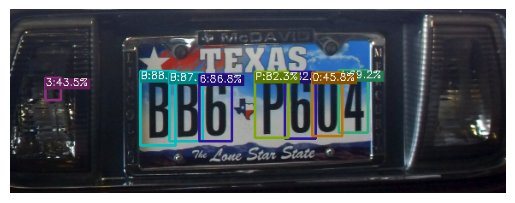

In [31]:
# test an image
image_path = "/content/example2.png"
# inference
outputs, img_info = predictor.inference(image_path)
# visualize prediction
result_image = predictor.visual(outputs[0], img_info, predictor.confthre)

# use plt library to display the image
plt.figure()
plt.imshow(result_image[..., ::-1])
_ = plt.axis("off")